# Simple example of ICIM usage

In [1]:
from __future__ import division
import sys
import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_style("ticks")
sns.set_context("talk")

sys.path.append("../resources/")
import sct

pd.options.mode.chained_assignment = None  # default='warn'

# Load data

In [4]:
# Example data is 902 GH146+ neurons
df = pd.read_csv("../data/df_GH146_Fig2.csv", sep=",", header=0, index_col=0) # CPM
df_libs = pd.read_csv("../data/libs.csv", sep=",", header=0, index_col=0) # sample info

In [10]:
# Rename df for convenience
X = df

# Identify marker genes using ICIM

In [13]:
reload(sct)
myICIM = sct.ICIM(X, df, TFs=[], CSMs=[], exclude=[], N=100,
                  correlation_cutoff=0.5,
                  min_hits=3,
                  exclude_max=2,
                  dropout_rate_low=0.3,
                  dropout_rate_high=1.0,
                  metric="correlation",
                  stop_condition="linkage_dist",
                  N_stop=50,
                  linkage_dist_stop=0.2)

In [15]:
myICIM.step("0", verbose=True) # for testing one step

Found 8 genes
Child populations 637 265


['00', '01']

In [17]:
myICIM.calc(verbose=True)

Initial step
Found 8 genes
Child populations 637 265

01
Found 23 genes
Child populations 87 178

011
Found 11 genes
Child populations 37 141

0111
Found 7 genes
Child populations 131 10

01110
Found 0 genes

0110
Found 329 genes
Failed linkage distance condition. Stopping.

010
Found 82 genes
Child populations 45 42

0100
Found 172 genes
Failed linkage distance condition. Stopping.

0101
Found 240 genes
Failed linkage distance condition. Stopping.

00


MemoryError: 

In [18]:
genes_GH146_ICIM = myICIM.get_all_markers()
print "Genes found by ICIM", len(genes_GH146_ICIM)

Genes found by ICIM 105


# Display cells using ICIM/TSNE

In [19]:
# Subset data to genes desired
Y = X.loc[genes_GH146_ICIM]

# Calculate TSNE
reload(sct)
from sklearn.manifold import TSNE
myTSNE = sct.TSNE(Y, df, df_libs)
myTSNE.calc_TSNE(perplexity=10, learning_rate=250, early_exaggeration=4.0, method="exact", random_state=1)

[t-SNE] Computed conditional probabilities for sample 902 / 902
[t-SNE] Mean sigma: 0.130236
[t-SNE] Iteration 25: error = 18.7140167, gradient norm = 0.1538079
[t-SNE] Iteration 50: error = 17.0647780, gradient norm = 0.1446399
[t-SNE] Iteration 75: error = 16.3444361, gradient norm = 0.1383223
[t-SNE] Iteration 100: error = 15.5661495, gradient norm = 0.1348827
[t-SNE] Error after 100 iterations with early exaggeration: 15.566149
[t-SNE] Iteration 125: error = 1.2868814, gradient norm = 0.0067263
[t-SNE] Iteration 150: error = 1.2375564, gradient norm = 0.0052326
[t-SNE] Iteration 175: error = 1.2345823, gradient norm = 0.0080636
[t-SNE] Iteration 200: error = 1.2371598, gradient norm = 0.0079599
[t-SNE] Iteration 225: error = 1.2518660, gradient norm = 0.0091198
[t-SNE] Iteration 250: error = 1.2513288, gradient norm = 0.0112901
[t-SNE] Iteration 250: did not make any progress during the last 50 episodes. Finished.
[t-SNE] Error after 250 iterations: 1.251329


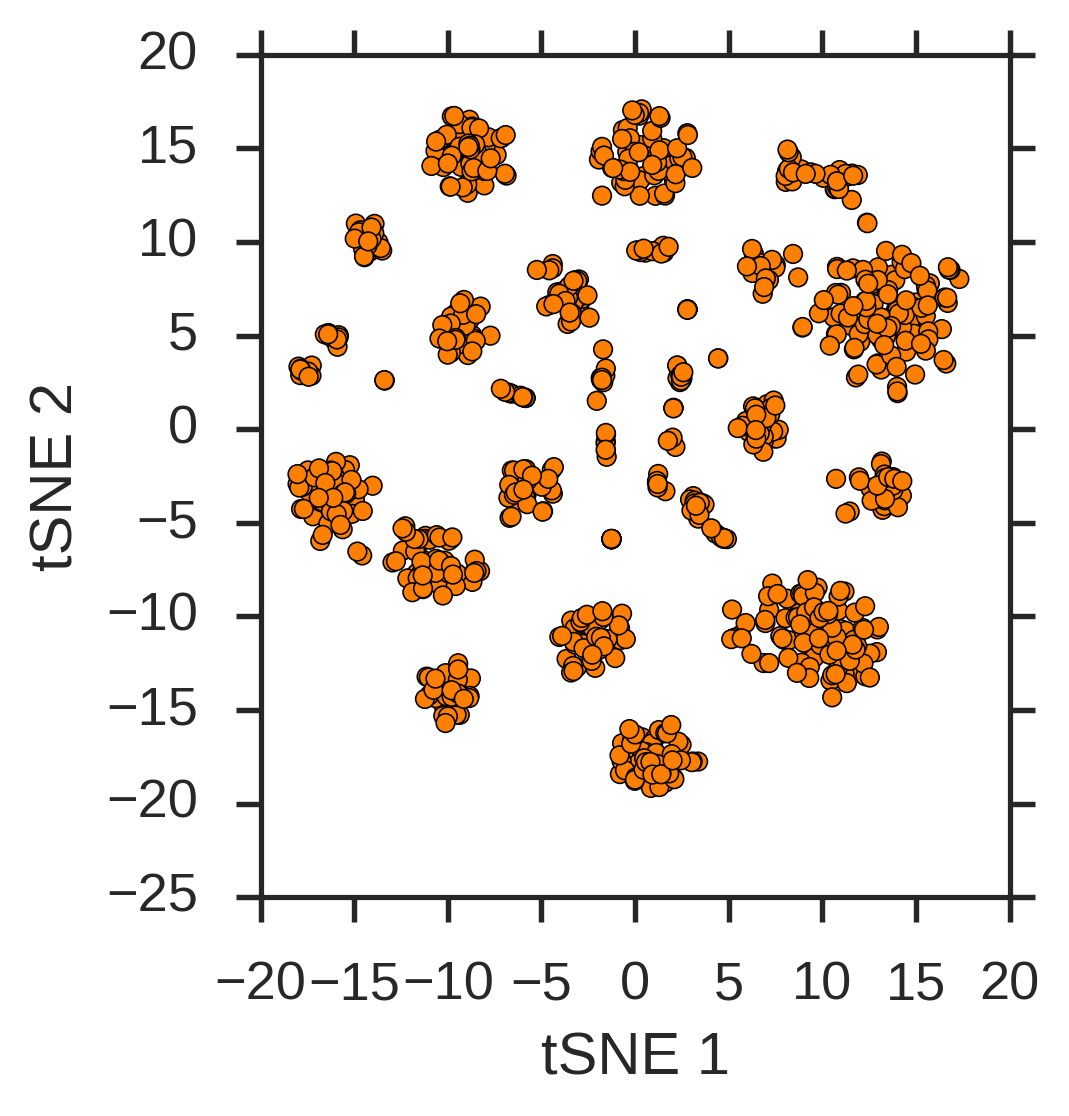

In [21]:
# Plot TSNE colored by genotype
fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorMode="genotype")

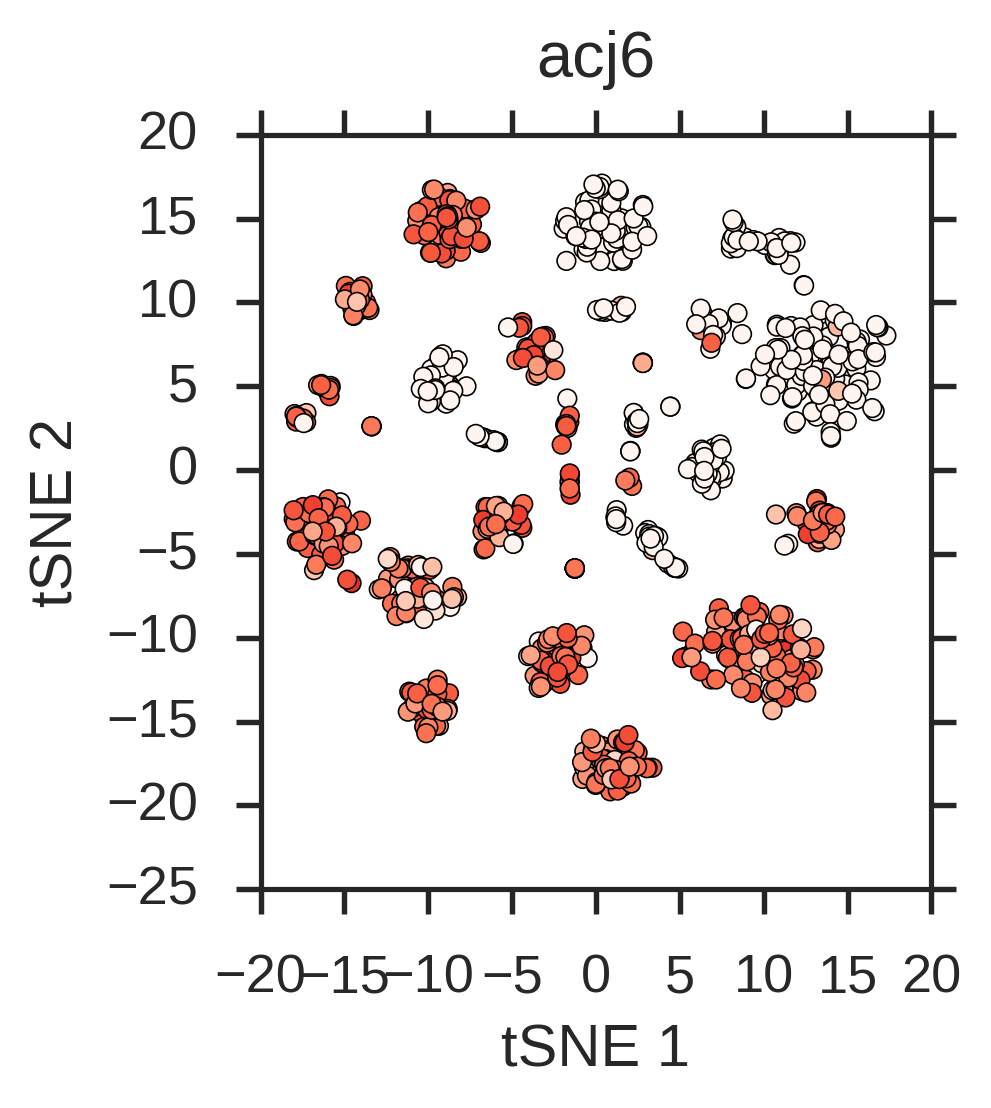

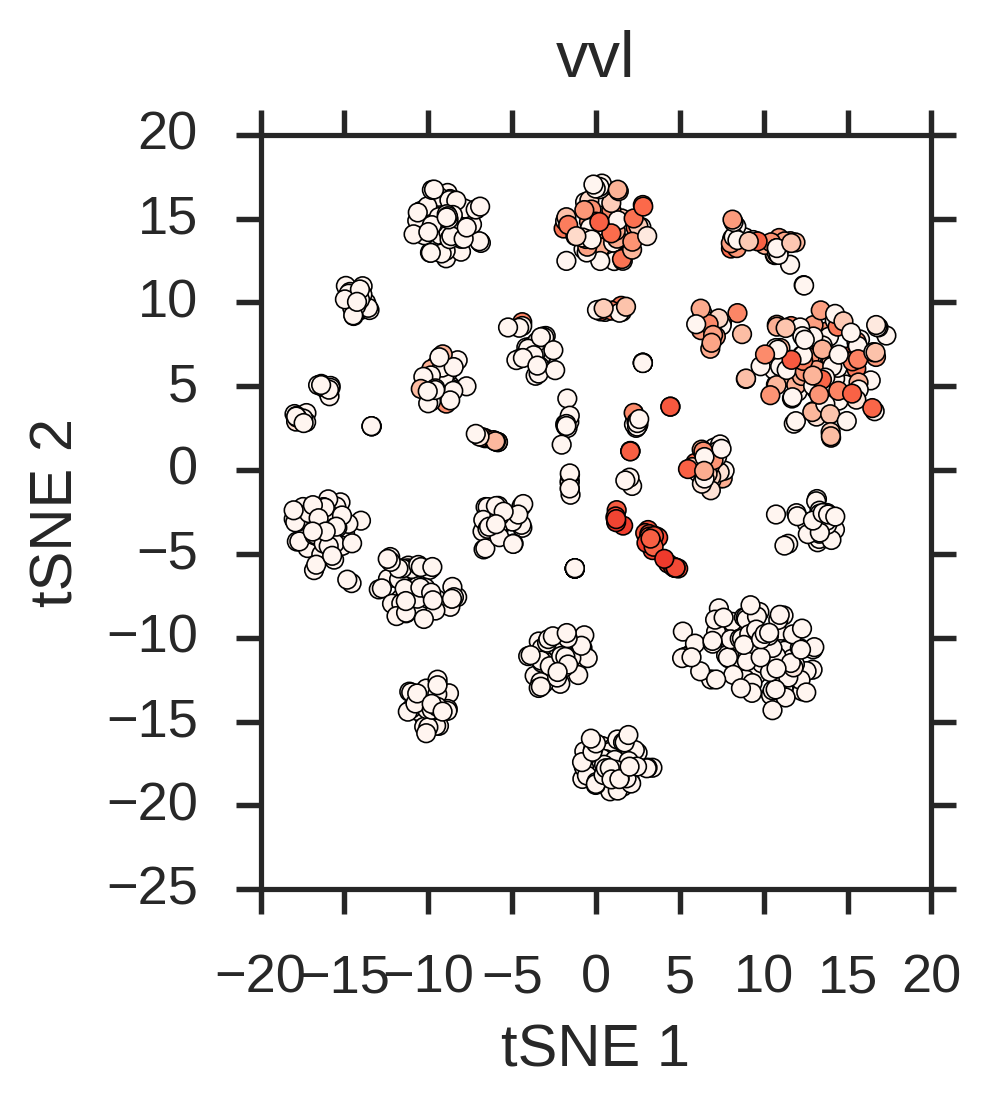

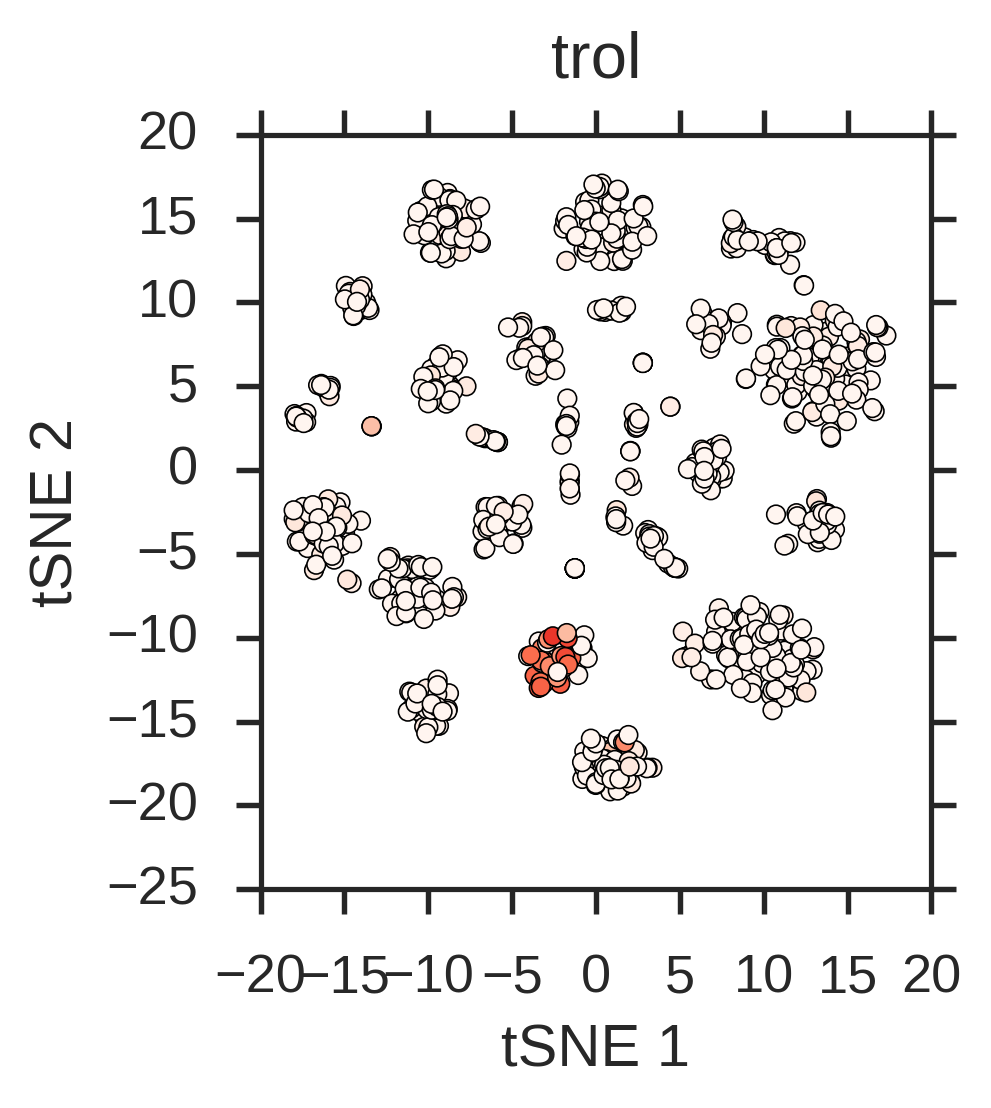

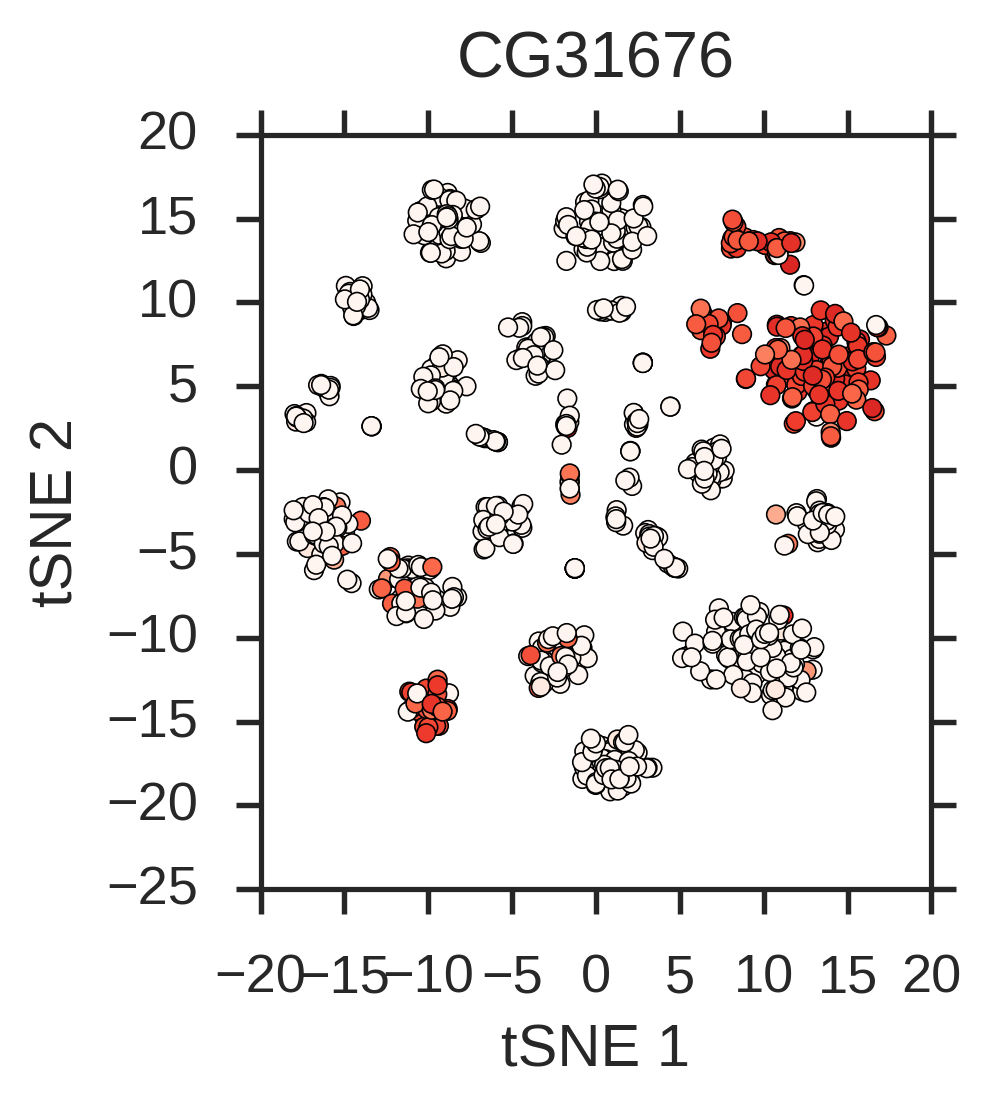

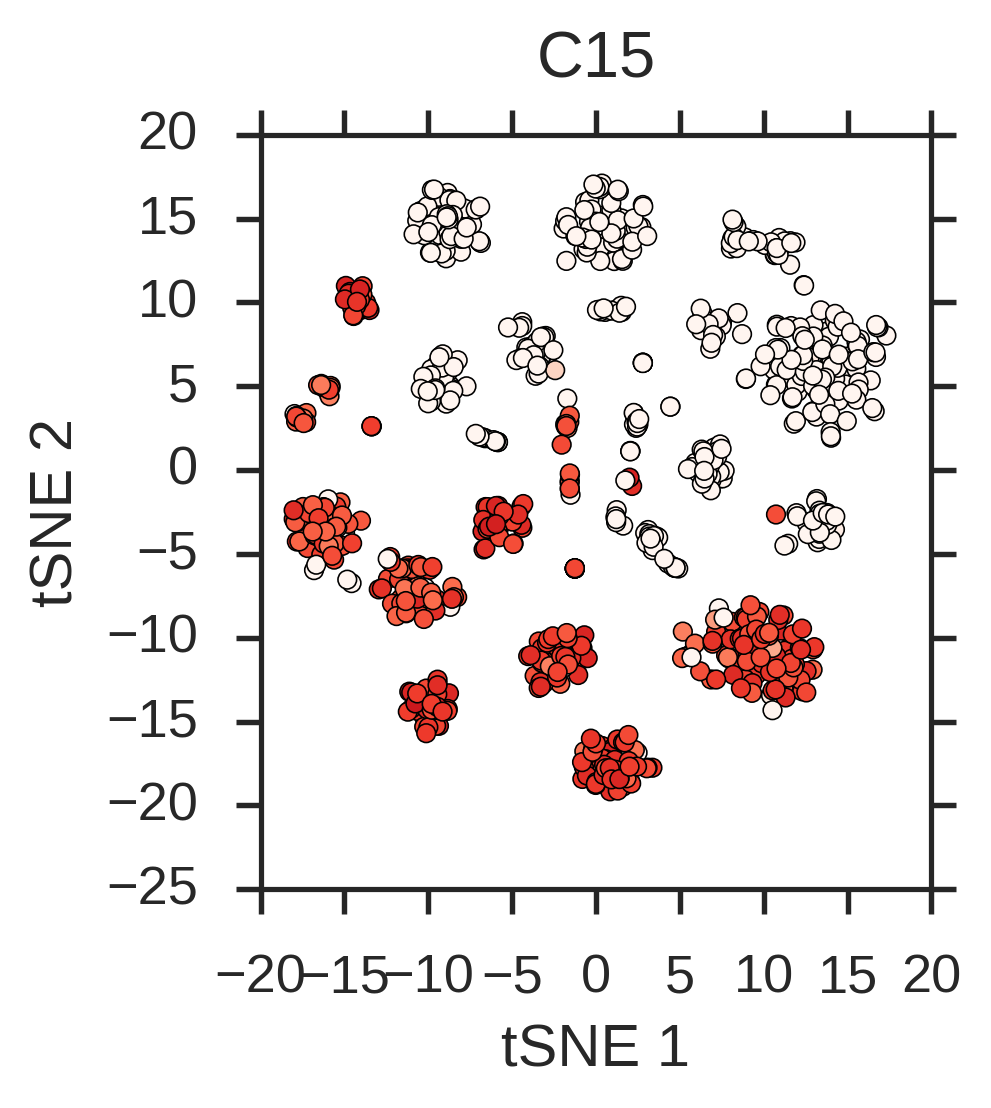

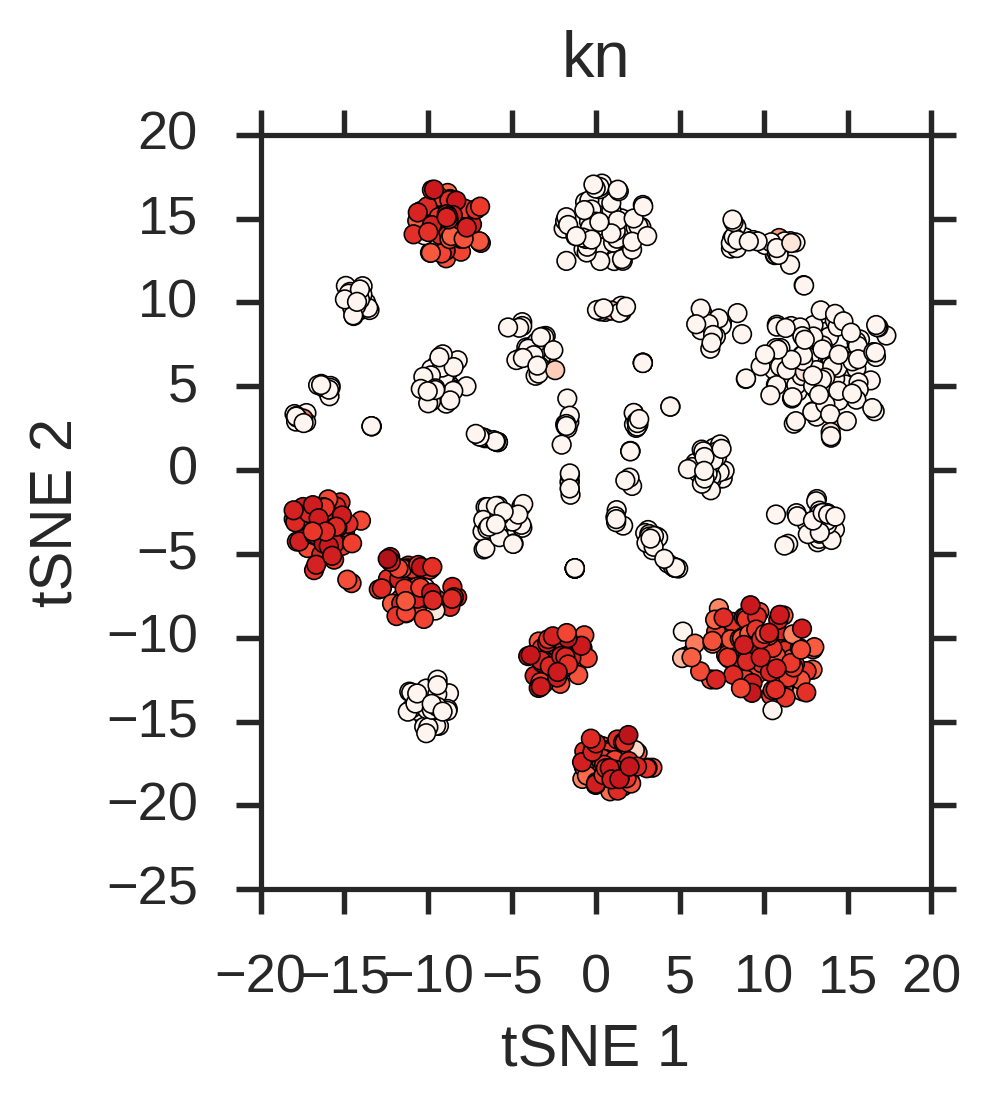

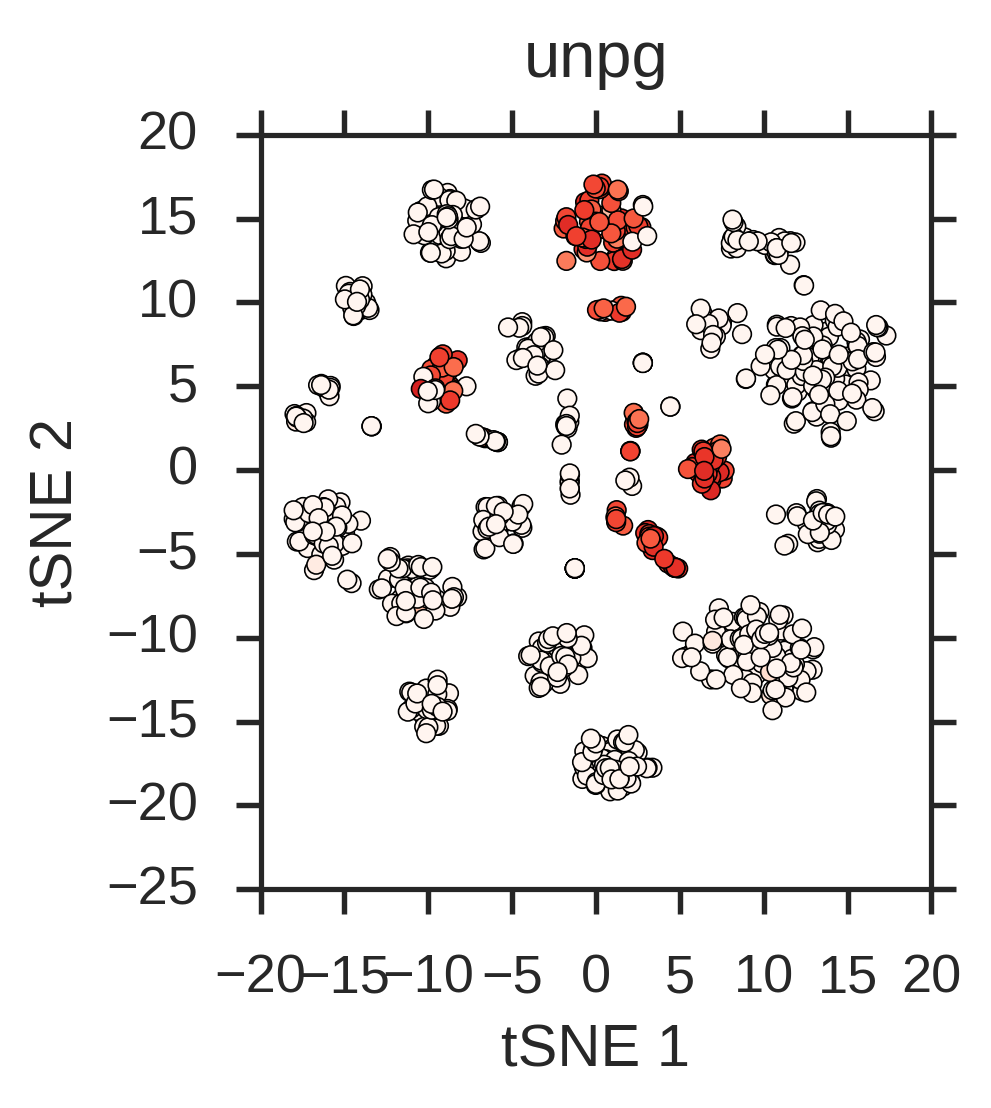

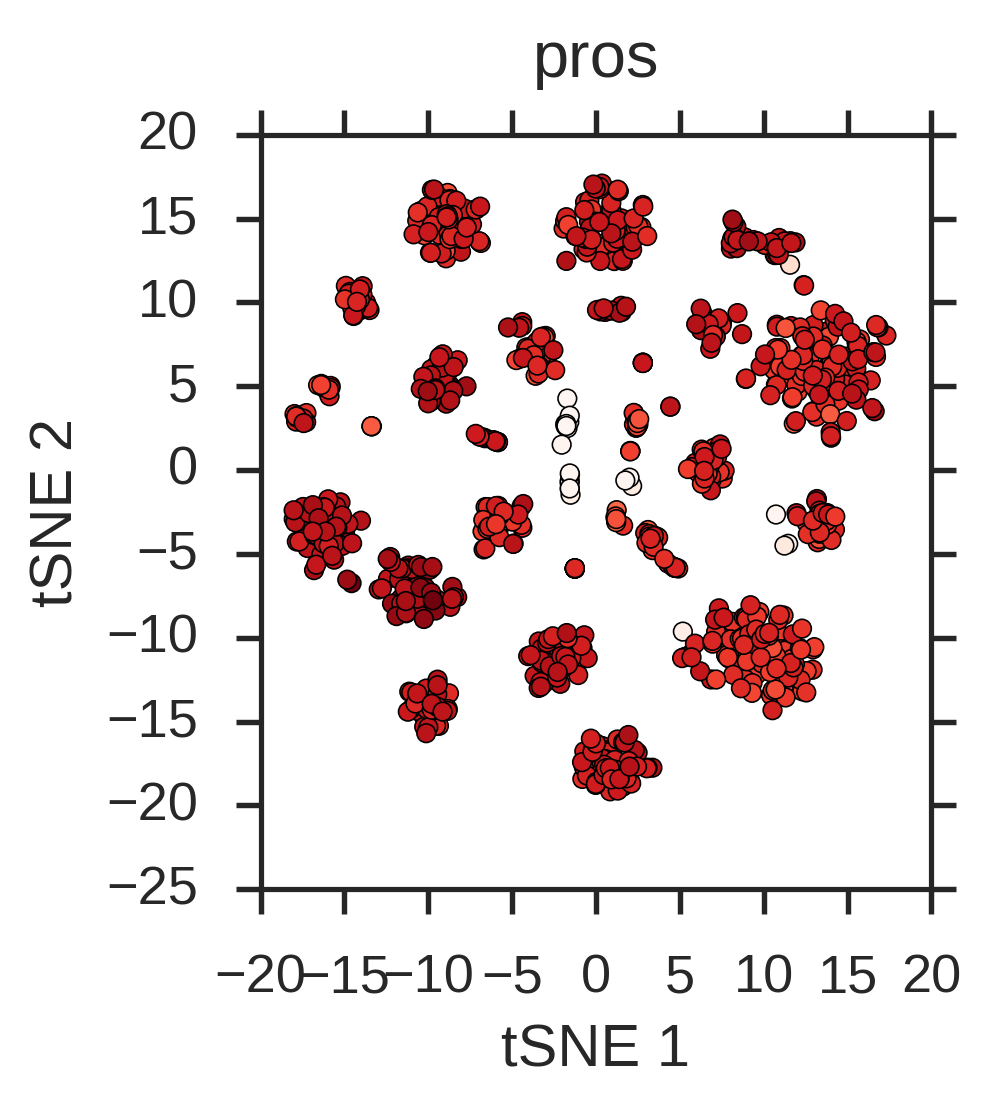

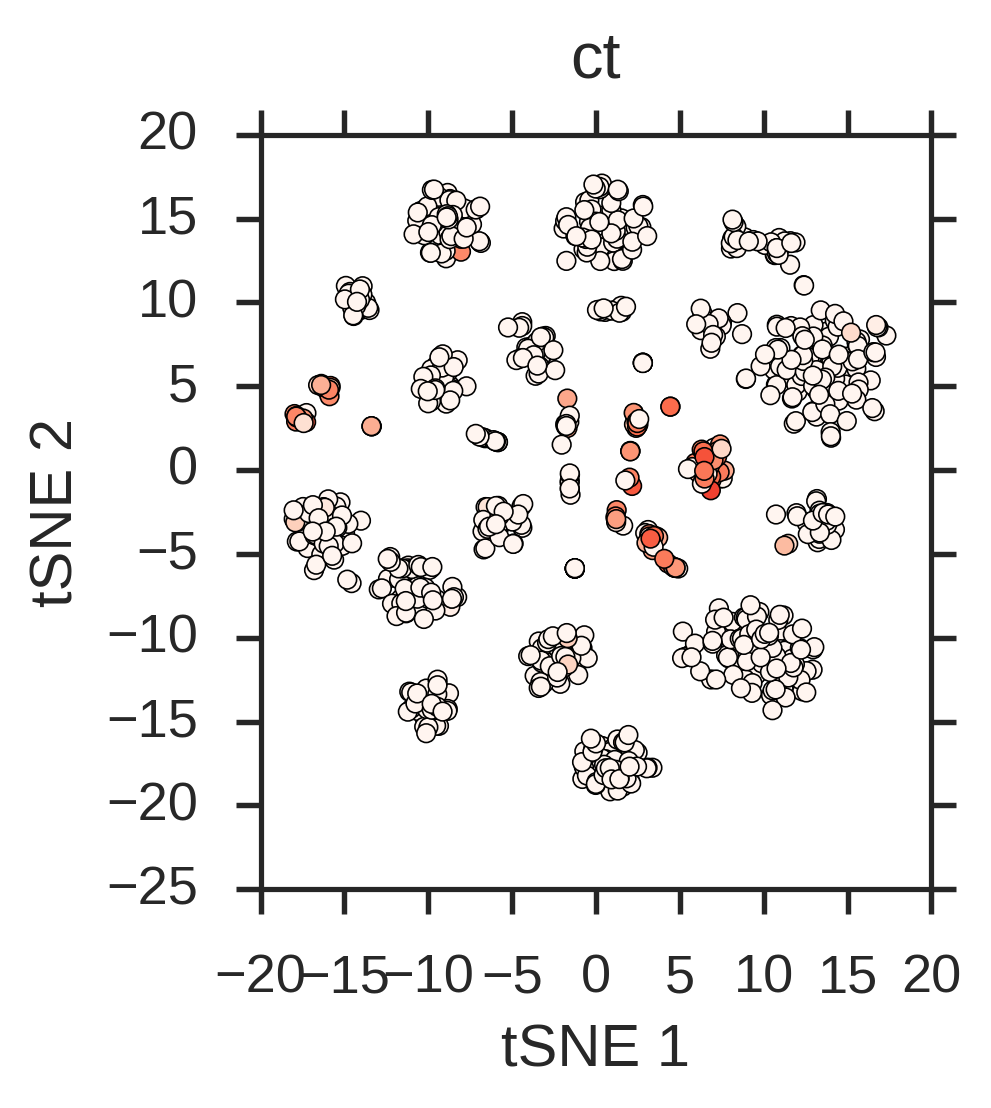

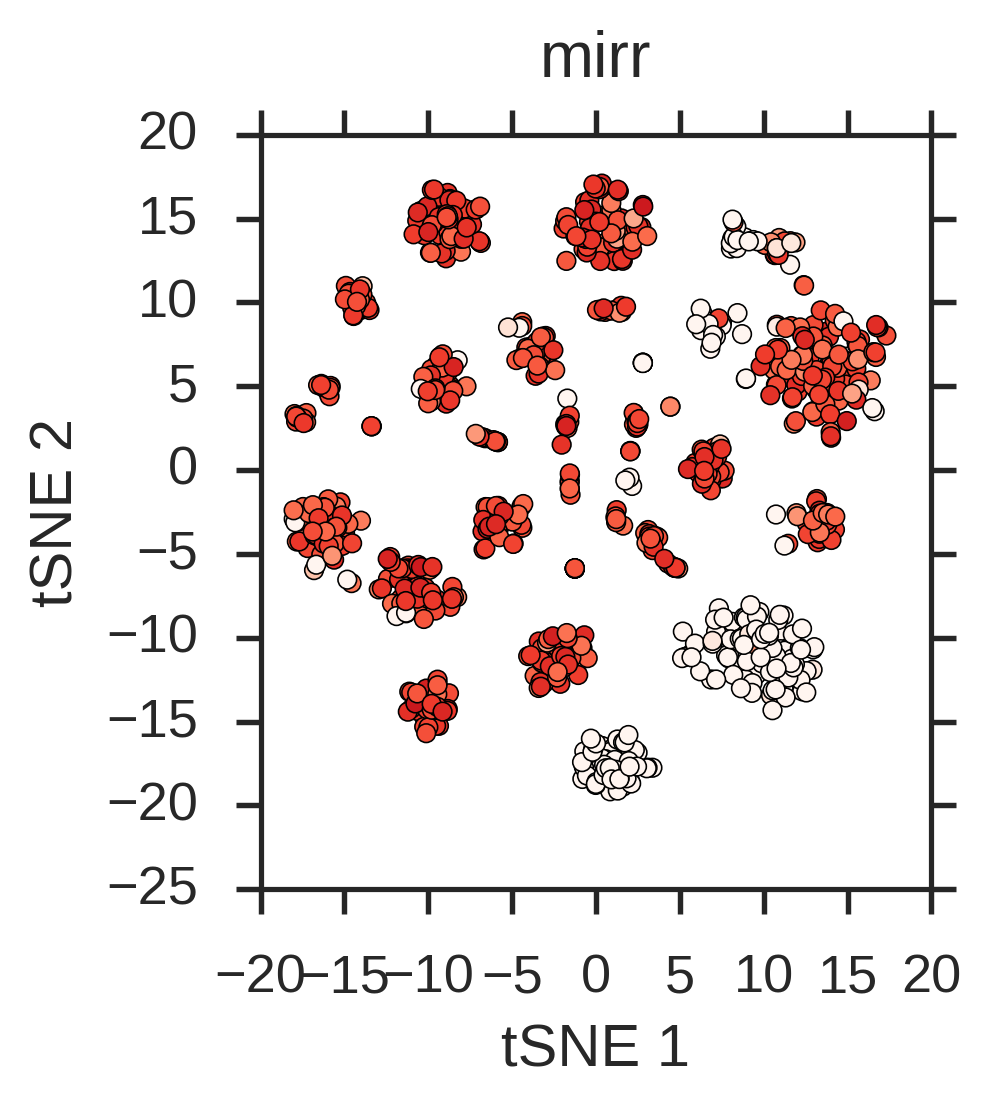

In [23]:
# Plot TSNE colored by expression levels
# Note that some of these plots are shown in Figure 5
myGenes = ["acj6", "vvl", "CG31676", "C15", "kn"]
for gene in myGenes:
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    myTSNE.plot(fig, ax, colorBy=gene, cmap="Reds")
    ax.set_title(gene, y=1.05)
    plt.tight_layout()

# Identify clusters using HDBSCAN

In [24]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3).fit(myTSNE.X_tsne)
labels_HDBSCAN = clusterer.labels_
print "Clusters", max(labels_HDBSCAN)+1

Clusters 30


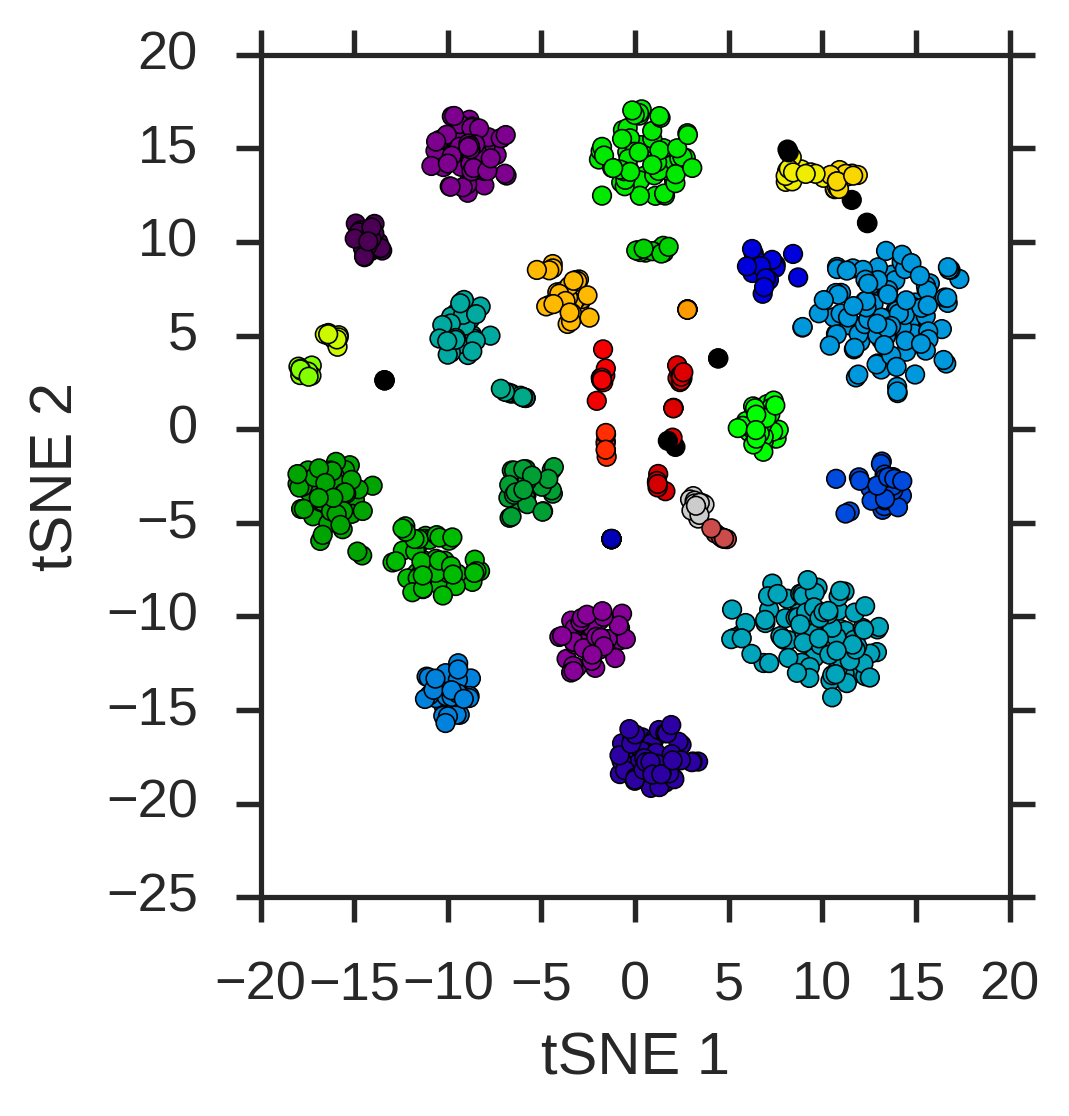

In [25]:
# Plot TSNE colored by cluster assignment
fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorMode="custom", colorBy=labels_HDBSCAN, cmap="nipy_spectral")

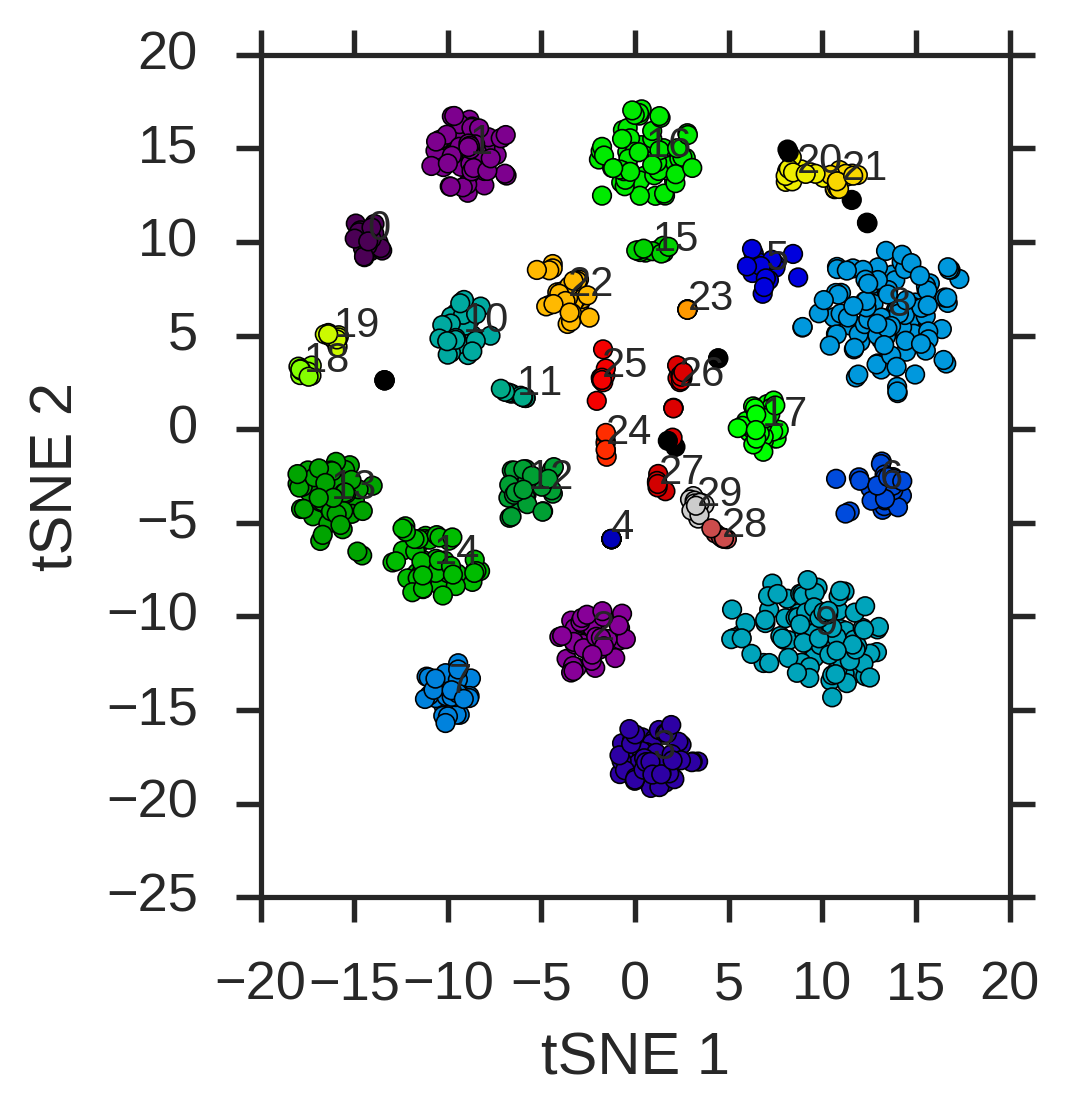

In [26]:
# Plot TSNE colored by cluster assignment with labels
fig, ax = plt.subplots(1, 1, figsize=(6,4))
myTSNE.plot(fig, ax, colorMode="custom", colorBy=labels_HDBSCAN, cmap="nipy_spectral")
for label in pd.Series(labels_HDBSCAN).value_counts().index:
    if label == -1: continue
    x_bar = np.mean(myTSNE.X_tsne[labels_HDBSCAN == label, 0])
    y_bar = np.mean(myTSNE.X_tsne[labels_HDBSCAN == label, 1])
    ax.text(x_bar, y_bar, label, size=10)

In [27]:
# Display cluster cell counts
print pd.Series(labels_HDBSCAN).value_counts()

 8     108
 9      93
 16     61
 1      53
 14     51
 13     51
 3      50
 2      43
 7      35
 10     32
 12     32
 6      30
 22     30
 17     28
 0      22
 5      21
 26     16
 29     15
 20     14
 19     13
 21     13
 15     12
 18     12
-1      12
 11     10
 4       9
 25      9
 28      9
 24      7
 27      6
 23      5
dtype: int64
